# 03 EDA and Baseline Model Testing
In this notebook, I will perform some basic EDA of my earnings transcripts, along with testing out some initial baseline models. I will be using pre-existing architecture, and then adding a classification layer on top of that. In the end, my goal is to get the model to predict whether the stock will move up or down in the next few days.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from tqdm import tqdm
import os
import warnings

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from gensim.models import Word2Vec
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
import evaluate

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, Lambda, Dense
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch

from datasets import Dataset, load_dataset

from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielwang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading in full dataset

In [34]:
os.getcwd()

'/Users/danielwang/Desktop/Work stuff/Coding Stuff/Berkeley Github Stuff/MIDS-DATASCI-266-Natural-Language-Processing/MIDS 266 Final Project Predicting Post-Earnings Announcement Drift Using NLP'

In [3]:
# Retrieving just to double check it can load
full_data_path = '/Users/danielwang/Desktop/Berkeley MIDS Stuff/Berkeley MIDS Summer 2025 Stuff/Berkeley MIDS DATASCI 266/Berkeley MIDS DATASCI 266 Project Material/SNP500_Transcripts_Price_2010_to_2024.csv'
full_data = pd.read_csv(full_data_path, sep='|', index_col=0)

full_data

,Date,Next_biz_day,Company_name,Ticker,Word_count,Text,Open,Close,Close_1,Close_2,Close_5,Close_0_dir,Close_1_dir,Close_2_dir,Close_5_dir
0,2015-01-06 21:30:00,2015-01-07,"Micron Technology, Inc.",MU,5184,"Good afternoon. My name is Karen, and I'll be ...",30.795428,31.352146,32.885567,32.748825,29.349901,1.0,1.0,1.0,0.0
1,2015-01-08 15:30:00,2015-01-09,"Constellation Brands, Inc.",STZ,3188,"Ladies and gentlemen, thank you for standing b...",92.797200,93.153008,92.831917,92.250504,96.849953,1.0,1.0,0.0,1.0
2,2015-01-12 22:00:00,2015-01-13,Alcoa Inc.,AA,7601,"Good day, ladies and gentlemen, and welcome to...",37.120452,35.610390,33.694641,33.739716,35.880848,0.0,0.0,0.0,0.0
3,2015-01-14 13:30:00,2015-01-15,CSX Corporation,CSX,1909,"Good morning, ladies and gentlemen, and welcom...",9.566863,9.651751,9.863967,9.773422,9.753616,1.0,1.0,1.0,1.0
4,2015-01-14 13:30:00,2015-01-15,JPMorgan Chase & Co.,JPM,2758,"Good morning, ladies and gentlemen, and welcom...",41.869368,41.313416,42.019623,41.854340,42.583084,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17228,2024-12-19 16:00:00,2024-12-20,FactSet Research Systems Inc.,FDS,2585,"Good day, and thank you for standing by. Welco...",482.339360,481.274323,487.067291,489.067993,480.438232,0.0,1.0,1.0,0.0
17229,2024-12-19 16:00:00,2024-12-20,Lennar Corporation,LEN,5361,Welcome to Lennar's Fourth Quarter Earnings Co...,131.804181,131.985794,131.909332,131.909332,130.188751,1.0,1.0,1.0,0.0
17230,2024-12-19 22:00:00,2024-12-20,"NIKE, Inc.",NKE,4496,"Good afternoon, everyone. Welcome to NIKE, Inc...",75.078526,76.047157,75.869247,75.898895,73.783737,1.0,1.0,1.0,0.0
17231,2024-12-19 22:30:00,2024-12-20,FedEx Corporation,FDX,5256,"Good day, and welcome to the FedEx Fiscal Year...",290.526486,272.472351,265.831726,268.628265,277.235382,0.0,0.0,0.0,0.0


# EDA on Data
I will be performing some basic EDA on my transcript dataset, analyzing text statistics and performing some ngram exploration.

## Analyzing text statistics
I'll start with just getting some string and word lengths (with their averages) and seeing if there's a large discrepancy between that. This way, we can get an initial sense of how many words are said, along with the length of the words and such.

*Note: I used this [article](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools#:~:text=Exploratory%20data%20analysis%20is%20one,Language%20Processing%20is%20no%20different) as guidance for the transcript analysis portion of my EDA.

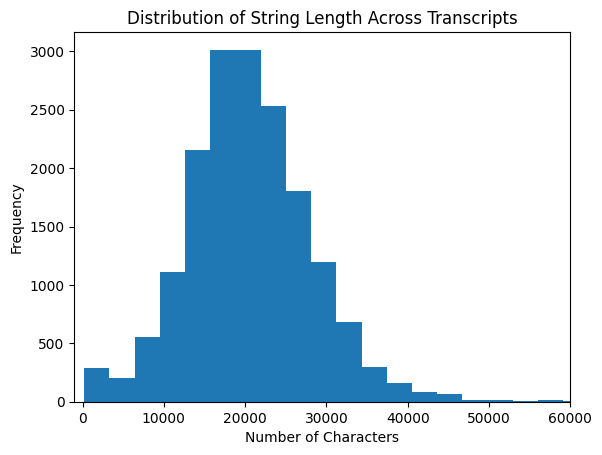

In [14]:
# Getting the string length of my data
plt.hist(full_data['Text'].str.len(), bins=50)
plt.xlim(-1000, 60000)
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of String Length Across Transcripts')

plt.show()

Aside from a few outliers, the string length seems mostly normally distributed.

Next, for the word count, while we already have a word count feature from Capital IQ, let's see how closely it matches the actual word counts of the transcripts.

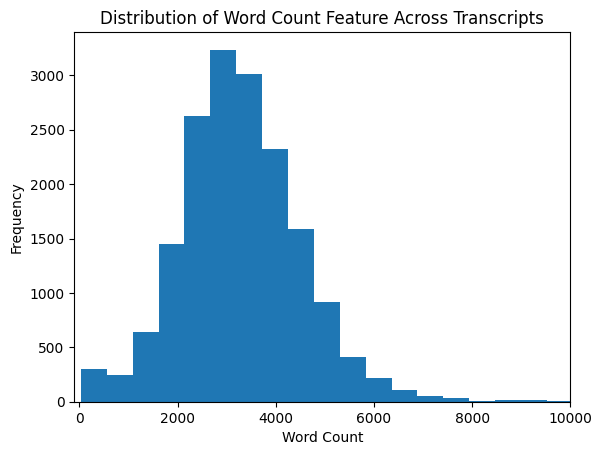

In [21]:
# Getting the distribution of word count feature
plt.hist(full_data['Word_count'], bins=50)
plt.xlim(-100, 10000)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count Feature Across Transcripts')

plt.show()

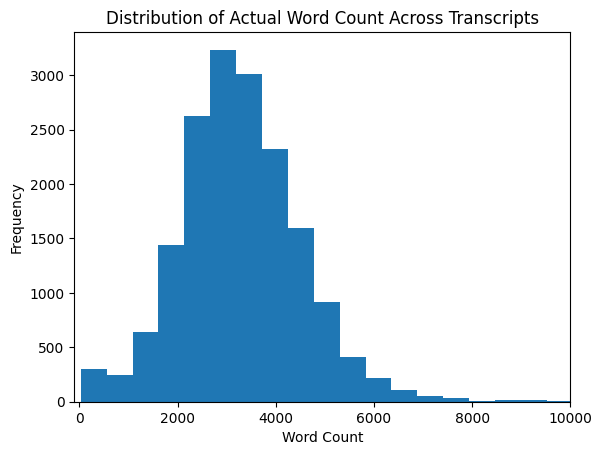

In [22]:
# Getting the distribution of actual word count
plt.hist(full_data['Text'].str.split().map(lambda x: len(x)), bins=50)
plt.xlim(-100, 10000)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Word Count Across Transcripts')

plt.show()

While it may be slightly off by a few words, the word count feature (again, from Capital IQ) does match our manual check.

Next, let's check the average word length in each sentence.

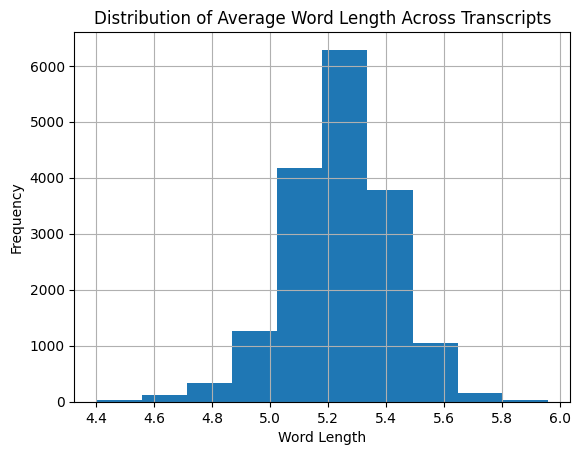

In [25]:
# Checking the average word length in each transcript
plt.hist(full_data['Text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)))
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Average Word Length Across Transcripts')

plt.grid()
plt.show()

As expected, the average word length in the transcript ranges from 4.4 to 6.0. This isn't too surprising as we're well within the Central Limit Theorem, but it's good to confirm that earnings call transcripts still follow the expected outcome.

Next, let's take a look at the stopwords and see what comes up.

In [34]:
# Loading in the stopwords
nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# Creating the corpus
tscrpt = full_data['Text'].str.split()
tscrpt = tscrpt.values.tolist()
corpus = [word for i in tscrpt for word in i]

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

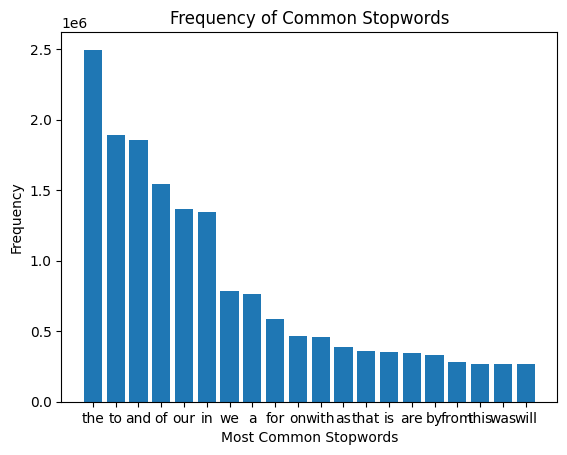

In [62]:
# Visualizing the most common words
stop_df = pd.DataFrame.from_dict(dic, orient='index')
stop_df = stop_df.sort_values(by=0, ascending=False)

# Getting a bar graph of the top 20 most common words
plt.bar(stop_df.index[:20], stop_df[:20][0])
plt.xlabel('Most Common Stopwords')
plt.ylabel('Frequency')
plt.title('Frequency of Common Stopwords')

plt.show()

There's nothing too surprising here, but let's now remove these words from the equation and see what other common words show up.

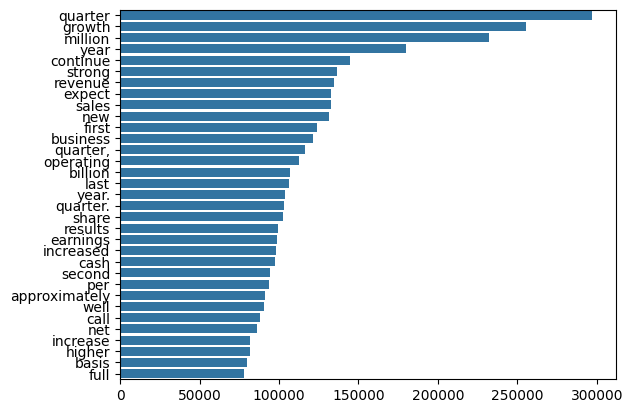

In [81]:
# Getting a counter of the common words (not in stopwords)
counter = Counter(corpus)
most = counter.most_common()

# Adding additional words to stopwords
additional_words = ['We', 'The', 'I', 'In', 'Our', 'And', 'As', 'also', 'This', 'Us', 'us']
stop.update(additional_words)

# Plotting the count of those common words
x, y = [], []
for word, count in most[:80]:
    if word not in stop:
        x.append(word)
        y.append(count)

sns.barplot(x=y, y=x)
plt.show()

This is more interesting. Firstly, we see general financial terms you would expect to hear from an earnings call - quarter, year, sales, business, million, billion, etc.. However, we can see that aside from those words, everything else is positive language - strong, increased, higher, etc.. This could indicate right off the bat that earnings calls are generally more positive, and that the companies' executive teams want to emphasize their successes.

While this isn't surprising, it's a good sign that the language in these transcripts matches what we expect to see, and it indicates that we extracted and cleaned our data properly.

## Ngram exploration
We can take what we did a step further by analyzing the most common *phrases* in the transcripts. Specifically, we might be able to better understand the context in which common words were used by looking at the most frequent n-grams.

In [98]:
# Defining a function to analyze top ngrams in our transcripts
def get_top_ngram(corpus, top_num=10, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:top_num]

<Axes: >

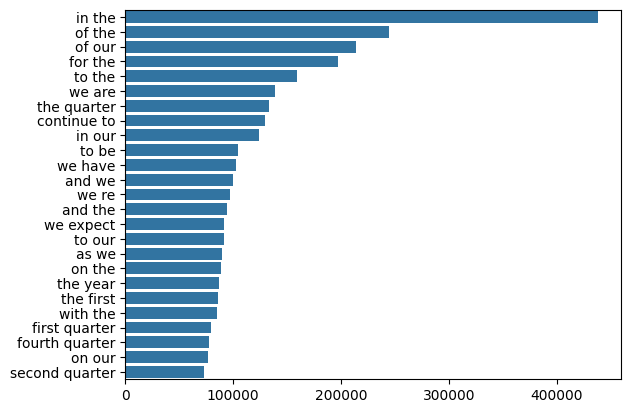

In [101]:
# Getting the top bigrams and plotting
top_25_bigrams = get_top_ngram(full_data['Text'], 25, 2)
x, y = map(list, zip(*top_25_bigrams))
sns.barplot(x=y,y=x)

The bigrams don't tell us much, mainly because there are a lot of common phrases in there. Let's check if trigrams are better.

<Axes: >

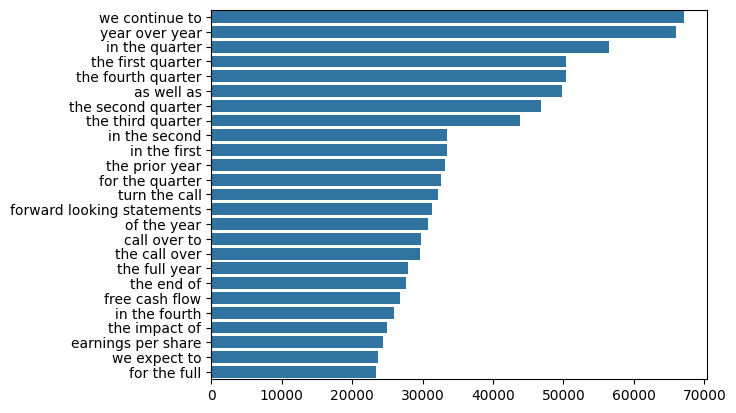

In [102]:
# Getting the top trigrams and plotting
top_25_trigrams = get_top_ngram(full_data['Text'], 25, 3)
x, y = map(list, zip(*top_25_trigrams))
sns.barplot(x=y,y=x)

The trigrams do indeed tell us more, and we notice some expected financial phrases among the trigrams (i.e., talking about quarters, years, and cash flow). We likely won't get too much more information from the ngrams alone, but it's helpful to get a gauge of what baseline phrases are common across all earnings calls.

## Target variable exploration
Now that we've explored our text, we can check the distribution of our target variables.

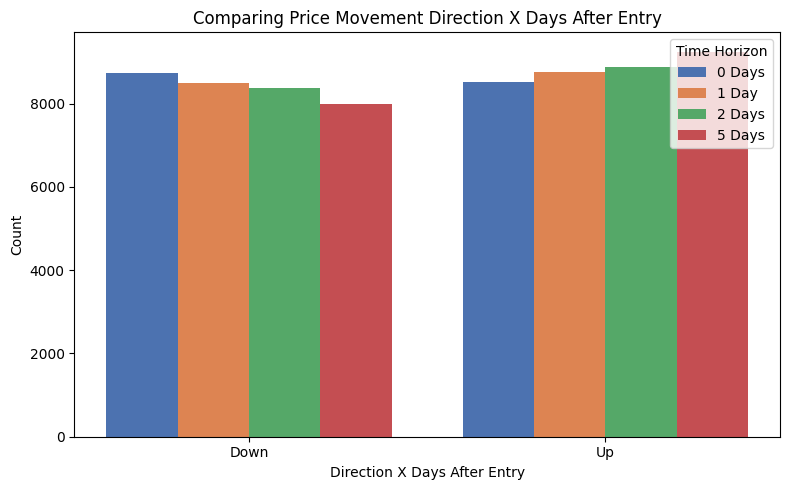

In [132]:
# Counting 0s and 1s for each column
target_columns = ['Close_0_dir', 'Close_1_dir', 'Close_2_dir', 'Close_5_dir']
target_labels = ['0 Days', '1 Day', '2 Days', '5 Days']
target_colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52']
target_cols_0 = [full_data[col].value_counts().get(0, 0) for col in target_columns]
target_cols_1 = [full_data[col].value_counts().get(1, 0) for col in target_columns]

# Getting the positions of the x-axes
bar_width = 0.2
x_base_0 = 0
x_base_1 = 1
x_0 = [x_base_0 + i * bar_width for i in range(len(target_columns))]
x_1 = [x_base_1 + i * bar_width for i in range(len(target_columns))]

# Plotting the direction of the target variables
plt.figure(figsize=(8, 5))
for i in range(len(target_columns)):
    plt.bar(x_0[i], target_cols_0[i], width=bar_width, color=target_colors[i], label=target_labels[i])
    plt.bar(x_1[i], target_cols_1[i], width=bar_width, color=target_colors[i])

# Adding x-ticks in the middle of each cluster
xtick_positions = [x_base_0 + (len(target_columns)-1)*bar_width/2, x_base_1 + (len(target_columns)-1)*bar_width/2]
plt.xticks(xtick_positions, ['Down', 'Up'])

# Adding legend and labels
plt.xlabel('Direction X Days After Entry')
plt.ylabel('Count')
plt.title('Comparing Price Movement Direction X Days After Entry')
plt.legend(title='Time Horizon')
plt.tight_layout()
plt.show()

This is quite interesting; it appears that as the time horizon increases, so do the number of upward-moving stocks (compared to the entry). This may, of course, simply be due to stock prices generally going upwards over time, especially for stocks in the S&P500. However, it could also be due to sentiment changes after earnings calls. For example, if the initial reaction of an earnings call was negative, the initial jump may be severe, but investors may come to realize that things weren't as bad as that initial reaction. Conversely, if the initial reaction of an earnings call was positive, investors may want to "ride that high" and continue focusing on the positives (while paying less attention to potentially underlying negative sentiment in the earnings call).

Either way, this gives us a decent baseline of what target variable we want to use. Going with the 0-day time horizon (i.e., entering and exiting on the same day) will provide a more balanced class split. However, we may lose the predictive power that a longer time horizon may provide (since a longer time frame will allow the post-earnings price movement to stabilize into a true direction). Therefore, we'll stick with a time horizon of 5 days, meaning that we'll **predict the movement of the stock one week after we enter**. *(Note that this will allows us to measure the drift - and deliberately avoid measuring the initial jump - since our entry is always the day after the earnings call)*

# Baseline Models
We'll start with a few baseline models, notably, a most-common-class predictor and a DAN model.

## Limiting the data to only the text and the chosen outcome variable
To run the models, I really only need the columns containing the text and the outcome variable. Since our model is not autoregressive - and we're essentially just doing classification - the dates and times don't matter for us. We'll end up randomizing our train and test sets, and we're ultimately just trying to predict the stock price drift after *any* earnings call, regardless of time or stock.

In [4]:
# Creating a new dataframe for just what we need
model_df = full_data[['Text', 'Close_5_dir']].copy()

model_df

,Text,Close_5_dir
0,"Good afternoon. My name is Karen, and I'll be ...",0.0
1,"Ladies and gentlemen, thank you for standing b...",1.0
2,"Good day, ladies and gentlemen, and welcome to...",0.0
3,"Good morning, ladies and gentlemen, and welcom...",1.0
4,"Good morning, ladies and gentlemen, and welcom...",1.0
...,...,...
17228,"Good day, and thank you for standing by. Welco...",0.0
17229,Welcome to Lennar's Fourth Quarter Earnings Co...,0.0
17230,"Good afternoon, everyone. Welcome to NIKE, Inc...",0.0
17231,"Good day, and welcome to the FedEx Fiscal Year...",0.0


## Most-common-class predictor
In this baseline, we'll simply be predicting the most common class for every earnings call (which from our EDA above, will be the "Up" class).

In [151]:
# Defining the most common class predictor
def most_common_class_predictor(target_var):

    # Simplying returning the first index of the value_counts() divided by the total
    majority_class = target_var.value_counts().index[0]
    majority_perc = target_var.value_counts().iloc[0] / len(target_var)

    return (majority_class, majority_perc)

In [153]:
# Getting the majority class predictor and the percent accuracy
majority_class, majority_accuracy = most_common_class_predictor(model_df['Close_5_dir'])

print('Most common class:', majority_class)
print('Accuracy of most common class predictor:', majority_accuracy)

Most common class: 1.0
Accuracy of most common class predictor: 0.5365867811756514


As expected, the most common class (or majority class) is Class 1 (meaning "Up") for the 5 day time horizon, with a ~54% accuracy. This will be the absolute baseline that our models must beat, though hopefully it will perform much better than this.

## Deep averaging network model
We'll now create our first NLP model - DAN (Deep Averaging Network) - and it will serve as a secondary baseline that will hopefully be an improvement over a simple majority class.

In [15]:
# Preprocessing and tokenizing the text
texts = model_df['Text'].astype(str).tolist()
labels = model_df['Close_5_dir'].astype(int).values

In [16]:
# Tokenizing each transcript
tokenized_texts = [word_tokenize(t.lower()) for t in texts]

# Training Word2Vec
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=300, window=5, min_count=5, workers=4)

In [20]:
# Building the embedding matrix and vocab dict
embedding_dim = w2v_model.vector_size
word_index = {word: i+1 for i, word in enumerate(w2v_model.wv.index_to_key)}  # +1 because 0 is reserved
word_index['[UNK]'] = len(word_index) + 1

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

This is where I'll have to make a concession. Because of the time it takes to create these sequences, I'll have to shorten it to 2,048. I will extend this when we move to later models, but this baseline will be based on a shorter sequence.

In [40]:
# Mapping words to IDs using vocab
def text_to_sequence(text, word_index, max_len=2048):
    tokens = word_tokenize(text.lower())
    ids = [word_index.get(word, word_index['[UNK]']) for word in tokens]
    return ids[:max_len]

# Converting text to sequences
sequences = [text_to_sequence(t, word_index) for t in texts]
padded_sequences = pad_sequences(sequences, maxlen=2048, padding='post', truncating='post')

In [41]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [42]:
# Defining the MAX_SEQUENCE_LENGTH
MAX_SEQUENCE_LENGTH = 2048

# Building the model (with an untrainable embedding matrix)
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(input_layer)

avg_layer = Lambda(lambda x: tf.reduce_mean(x, axis=1))(embedding_layer)
output_layer = Dense(1, activation='sigmoid')(avg_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/Users/danielwang/venv-metal/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 2048, 300)      │    16,127,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,128,001 (61.52 MB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 16,127,700 (61.52 MB)

In [43]:
# Training the model
model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), batch_size=32, epochs=5)

Epoch 1/5


2025-07-21 20:53:14.722622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5206 - loss: 0.6927 - val_accuracy: 0.5283 - val_loss: 0.6934
Epoch 2/5
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5208 - loss: 0.6924 - val_accuracy: 0.5277 - val_loss: 0.6930
Epoch 3/5
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5310 - loss: 0.6903 - val_accuracy: 0.5231 - val_loss: 0.6918
Epoch 4/5
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5335 - loss: 0.6907 - val_accuracy: 0.5283 - val_loss: 0.6904
Epoch 5/5
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5428 - loss: 0.6895 - val_accuracy: 0.5277 - val_loss: 0.6982


Evidently, the DAN model did not do a good job at predicting the classes, as the training and validation accuracies hovered around 52-53%, which is actually worse than our majority class baseline with an accuracy of ~54%. One likely reason for this is that the averaging process dilutes the signal - specifically, averaging word embeddings across a long transcript (some of which exceeded 9000 tokens originally) can cause important words or phrases to lose their influence, resulting in a weak signal for classification. This leads to the next point, which is that we cut off significant portions of the transcript, which likely caused the model to underperform even further. A third reason why this model did not perform well is simply due to its limited capacity in understanding the text. In essence, the DAN architecture is quite simplistic, and it has no contextual or sequential understanding (which likely limited its ability to capture the nuanced patterns and underlying tone in earnings call transcripts).

Nevertheless, this was a good baseline to establish, and we'll explore more advanced models with transformers or fine-tuned embeddings to better handle the length and complexity of the transcripts.

# Baseline ModernBERT Model
While the final baseline being a ModernBERT model seems like a dramatic jump from our previous baselines, I believe ModernBERT will be the first "good" model in terms of performance (as we barely achieved over 50% accuracy previously).

There are a few reasons why ModernBERT is a superior model, starting with the fact that it has a token input limit of 8,192, which should be more than sufficient to hold the majority of the transcript text. Secondly, BERT models like ModernBERT have contextual understanding of the text through the self-attention mechanism. This should be particularly valuable in earnings call transcripts, where the tone, implications, or sentiment may depend heavily on phrasing and local context. A third reason is that ModernBERT was trained on a large corpora and carries a broader general-purpose language understanding. Therefore, it might be able to perform better in a domain-specific setting like finance.

Ultimately, I'll see how ModernBERT performs, and follow-up on this model afterward.

## Testing ModernBERT Model
Just to make sure this model works for me, I'll run a test and see if I can get some results.

In [5]:
# Confirming that I see my GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Loading the ModernBERT model
mbert_checkpoint = "answerdotai/ModernBERT-base"
mbert_tokenizer = AutoTokenizer.from_pretrained(mbert_checkpoint)
mbert_model = AutoModel.from_pretrained(mbert_checkpoint)

In [7]:
# Testing ModernBERT with the some earnings transcript data to make sure it can function properly
tscrpt_1_text = model_df['Text'][2]

# Getting the tokens
mbert_inputs_tscrpt_1 = mbert_tokenizer(tscrpt_1_text, return_tensors="pt")
print(mbert_inputs_tscrpt_1)
print(mbert_inputs_tscrpt_1.input_ids.shape)

# Getting what the tokenizer feeds in
mtokens_tscrpt_1 = mbert_tokenizer.tokenize(tscrpt_1_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (9841 > 8192). Running this sequence through the model will result in indexing errors


{'input_ids': tensor([[50281,  8620,  1388,  ..., 14943,    32, 50282]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}
torch.Size([1, 9841])


While not always shown above, we did receive a warning that this transcript exceeds the token limit for ModernBERT. While this is fine for now, we need to be wary of this as we move forward.

In [8]:
# Checking the named parameters
for name, param in mbert_model.named_parameters():
    print(name)

embeddings.tok_embeddings.weight
embeddings.norm.weight
layers.0.attn.Wqkv.weight
layers.0.attn.Wo.weight
layers.0.mlp_norm.weight
layers.0.mlp.Wi.weight
layers.0.mlp.Wo.weight
layers.1.attn_norm.weight
layers.1.attn.Wqkv.weight
layers.1.attn.Wo.weight
layers.1.mlp_norm.weight
layers.1.mlp.Wi.weight
layers.1.mlp.Wo.weight
layers.2.attn_norm.weight
layers.2.attn.Wqkv.weight
layers.2.attn.Wo.weight
layers.2.mlp_norm.weight
layers.2.mlp.Wi.weight
layers.2.mlp.Wo.weight
layers.3.attn_norm.weight
layers.3.attn.Wqkv.weight
layers.3.attn.Wo.weight
layers.3.mlp_norm.weight
layers.3.mlp.Wi.weight
layers.3.mlp.Wo.weight
layers.4.attn_norm.weight
layers.4.attn.Wqkv.weight
layers.4.attn.Wo.weight
layers.4.mlp_norm.weight
layers.4.mlp.Wi.weight
layers.4.mlp.Wo.weight
layers.5.attn_norm.weight
layers.5.attn.Wqkv.weight
layers.5.attn.Wo.weight
layers.5.mlp_norm.weight
layers.5.mlp.Wi.weight
layers.5.mlp.Wo.weight
layers.6.attn_norm.weight
layers.6.attn.Wqkv.weight
layers.6.attn.Wo.weight
layers.6.mlp

In [9]:
# Getting the ModernBERT outputs
mbert_outputs_tscrpt_1 = mbert_model(**mbert_inputs_tscrpt_1)
mbert_outputs_tscrpt_1

BaseModelOutput(last_hidden_state=tensor([[[-0.1602,  0.0032, -1.1325,  ...,  0.0534,  0.3773,  0.0035],
         [-0.4544,  0.7715,  0.3651,  ...,  1.0890, -0.9595, -0.2745],
         [-0.6196, -0.3941,  0.3785,  ...,  1.8311,  0.4604, -0.4913],
         ...,
         [-0.7410, -0.7556,  0.0879,  ...,  0.2443, -0.1505,  0.5807],
         [-1.1962,  0.1347,  0.5087,  ..., -0.4418, -0.3822, -1.7417],
         [ 0.1623, -0.0426, -0.0304,  ...,  0.0601,  0.2260,  0.1928]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

In [10]:
# Getting the shape
mbert_outputs_tscrpt_1[0].shape

torch.Size([1, 9841, 768])

Now that we've confirmed that our model will work, we can start building the entire pipeline, including a final classification layer.

## ModernBERT classifier
The ModernBERT model already has a classification layer, which makes it very helpful for us to simply use.

In [22]:
# Getting the ModernBERT model with classification
mbert_classification_model = AutoModelForSequenceClassification.from_pretrained(mbert_checkpoint, num_labels=2)
mbert_classification_model.config.problem_type = "single_label_classification"

# Checking the named parameters
for name, param in mbert_classification_model.named_parameters():
    print(name)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.embeddings.tok_embeddings.weight
model.embeddings.norm.weight
model.layers.0.attn.Wqkv.weight
model.layers.0.attn.Wo.weight
model.layers.0.mlp_norm.weight
model.layers.0.mlp.Wi.weight
model.layers.0.mlp.Wo.weight
model.layers.1.attn_norm.weight
model.layers.1.attn.Wqkv.weight
model.layers.1.attn.Wo.weight
model.layers.1.mlp_norm.weight
model.layers.1.mlp.Wi.weight
model.layers.1.mlp.Wo.weight
model.layers.2.attn_norm.weight
model.layers.2.attn.Wqkv.weight
model.layers.2.attn.Wo.weight
model.layers.2.mlp_norm.weight
model.layers.2.mlp.Wi.weight
model.layers.2.mlp.Wo.weight
model.layers.3.attn_norm.weight
model.layers.3.attn.Wqkv.weight
model.layers.3.attn.Wo.weight
model.layers.3.mlp_norm.weight
model.layers.3.mlp.Wi.weight
model.layers.3.mlp.Wo.weight
model.layers.4.attn_norm.weight
model.layers.4.attn.Wqkv.weight
model.layers.4.attn.Wo.weight
model.layers.4.mlp_norm.weight
model.layers.4.mlp.Wi.weight
model.layers.4.mlp.Wo.weight
model.layers.5.attn_norm.weight
model.layers.5.at

In [12]:
# Getting the max length for ModernBERT
MAX_LEN = 8192

# Defining a function to tokenize the text
def tokenize_fn(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

In [13]:
# Splitting the data using train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    model_df['Text'].tolist(),
    model_df['Close_5_dir'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=model_df['Close_5_dir']
)

# Converting to dictionaries
train_dict = {'text': X_train, 'label': y_train}
val_dict = {'text': X_val, 'label': y_val}

# Creating HuggingFace Datasets
train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict(val_dict)

In [14]:
# Defining a function for computing the metrics
metric = evaluate.load('accuracy')

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
# Defining a preprocessing transcripts function for my earnings data
def preprocess_transcripts(data, tokenizer):
    texts = data['text']
    
    encoded = tokenizer.batch_encode_plus(
        texts,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )
    return {
    'input_ids': encoded['input_ids'],
    'attention_mask': encoded['attention_mask'],
    'label': data['label']
    }

In [21]:
# Creating a ModernBERT classification model
def fine_tune_classif_model_modernbert(classification_model,
                                       tokenizer,
                                       train_data,
                                       dev_data,
                                       layers_to_train=["classifier."],
                                       max_sequence_length=8192,
                                       batch_size=4,
                                       num_epochs=2,
                                       saved_output_dir="./modernbert_output_test"):

    # Getting the preprocessed data
    preprocessed_train_data = train_data.map(preprocess_transcripts, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_transcripts, batched=True, fn_kwargs={'tokenizer': tokenizer})

    # Freezing all model parameters except those explicitly listed
    for name, param in classification_model.named_parameters():
        if not any(x in name for x in layers_to_train):
            param.requires_grad = False

    training_args = TrainingArguments(
        output_dir=saved_output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        eval_strategy="epoch",
        save_strategy="epoch",
        report_to="none"
    )

    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=preprocessed_train_data,
        eval_dataset=preprocessed_dev_data,
        compute_metrics=compute_metrics
    )

    trainer.train()

In [33]:
# Getting some smaller testing data to make sure things work properly
train_data_small = train_dataset.select(range(800))
val_data_small = val_dataset.select(range(200))

# Calling the fine-tuning function and training on the model
fine_tune_classif_model_modernbert(
    classification_model=mbert_classification_model,
    tokenizer=mbert_tokenizer,
    train_data=train_data_small,
    dev_data=val_data_small,
    layers_to_train=["classifier."],
    max_sequence_length=MAX_LEN,
    batch_size=2,
    num_epochs=2,
    saved_output_dir="./modernbert_output"
)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/Users/danielwang/venv-metal/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.694410,0.525000
2,0.694000,0.694811,0.500000


/Users/danielwang/venv-metal/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ultimately, not even the ModernBERT baseline produced great results, and now our goal should be to find more appropriate models, fine-tune this one, or try other strategies to improve the accuracy.

I do want to point out, however, that this model was run with a less-than-ideal batch size and with fewer epochs than I would've liked. Furthermore, I used less than 10% of all the data I had, which also made the model less generalizable. Basically, due to the limitations that this model has, it might be more worth it to move onto something else. Additionally, even this simplified model took about an hour to run, it would've taken over 10x longer if I wanted to train on my whole dataset.

Due to that finding, I will choose to run my following models on Google Colab (rather than from my local computer). Hopefully Colab Pro's enhanced GPUs will make everything run faster, and I'll start testing it out in the next notebook.